In [9]:
# import pandas library
import pandas as pd
# import numpy library
import numpy as np
# import matplotlib library for plotting
import matplotlib.pyplot as plt
# import seaborn library for statistical data visualization
import seaborn as sns
# import scikit-learn libraries for machine learning tasks
from sklearn.model_selection import train_test_split, GridSearchCV
# import necessary classes and functions from scikit-learn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# import necessary classes for preprocessing and model evaluation
from sklearn.compose import ColumnTransformer
# import necessary classes for building machine learning pipelines
from sklearn.pipeline import Pipeline
# import necessary classes for handling missing values
from sklearn.impute import SimpleImputer
# import necessary classes for model selection and evaluation
from sklearn.linear_model import LogisticRegression
# import necessary classes for ensemble methods
from sklearn.ensemble import RandomForestClassifier
# import necessary classes for model evaluation metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

In [10]:
# For reproducibility
RANDOM_STATE = 42
sns.set_style('whitegrid')

In [11]:
df = pd.read_csv('Students Social Media Addiction.csv')

In [12]:
# 2. Peek at data
print(df.head())
print(df.info())
print(df.describe(include='all'))

   Student_ID  Age  Gender Academic_Level     Country  Avg_Daily_Usage_Hours  \
0           1   19  Female  Undergraduate  Bangladesh                    5.2   
1           2   22    Male       Graduate       India                    2.1   
2           3   20  Female  Undergraduate         USA                    6.0   
3           4   18    Male    High School          UK                    3.0   
4           5   21    Male       Graduate      Canada                    4.5   

  Most_Used_Platform Affects_Academic_Performance  Sleep_Hours_Per_Night  \
0          Instagram                          Yes                    6.5   
1            Twitter                           No                    7.5   
2             TikTok                          Yes                    5.0   
3            YouTube                           No                    7.0   
4           Facebook                          Yes                    6.0   

   Mental_Health_Score Relationship_Status  Conflicts_Over_Soc

In [13]:
# 3. Exploratory Data Analysis (EDA)
# 3.1 Missing value counts
print(df.isnull().sum())

Student_ID                      0
Age                             0
Gender                          0
Academic_Level                  0
Country                         0
Avg_Daily_Usage_Hours           0
Most_Used_Platform              0
Affects_Academic_Performance    0
Sleep_Hours_Per_Night           0
Mental_Health_Score             0
Relationship_Status             0
Conflicts_Over_Social_Media     0
Addicted_Score                  0
dtype: int64


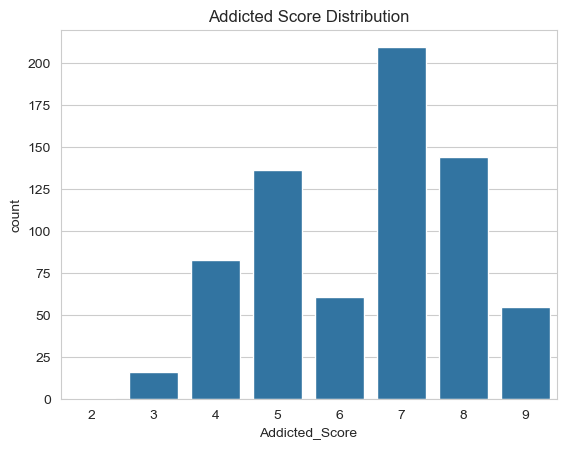

In [17]:
# 3.2 Target distribution (using 'Addicted_Score' as the label)
sns.countplot(x='Addicted_Score', data=df)
plt.title('Addicted Score Distribution')
plt.show()

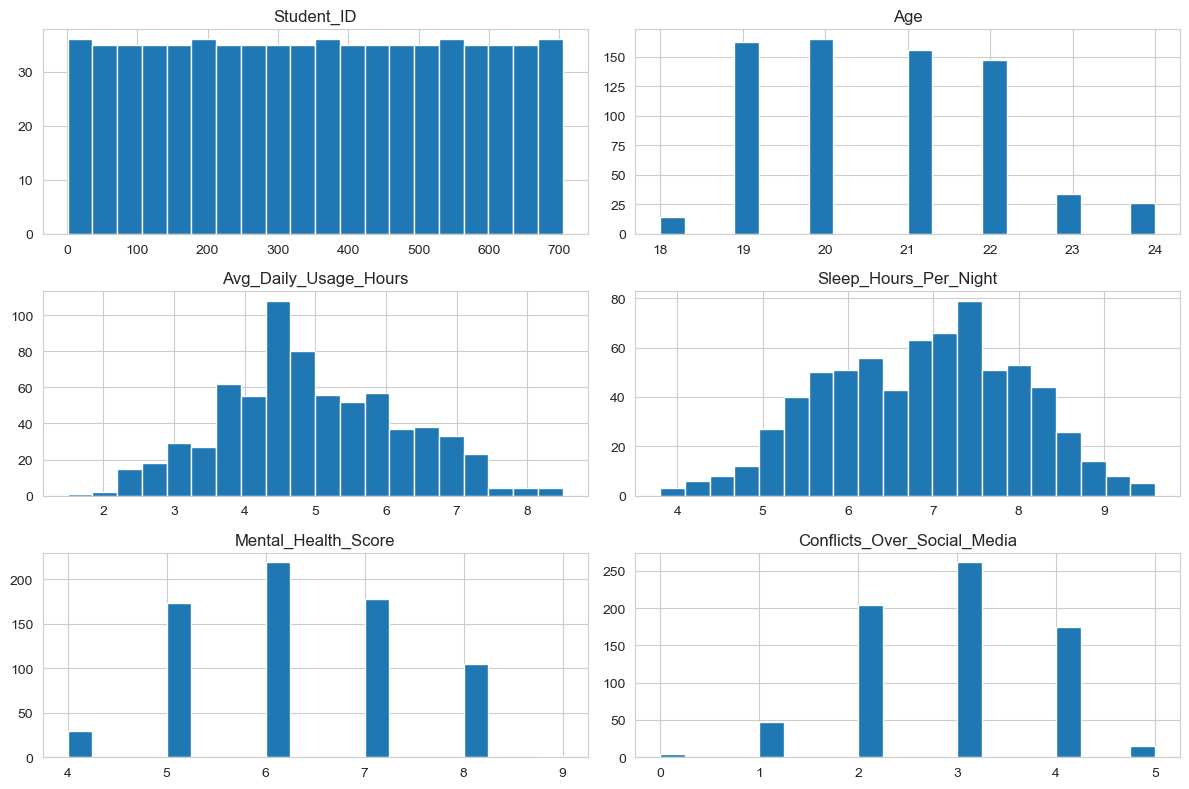

In [20]:
# 3.3 Histograms for numeric features
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('Addicted_Score')
df[num_cols].hist(bins=20, figsize=(12,8))
plt.tight_layout()
plt.show()

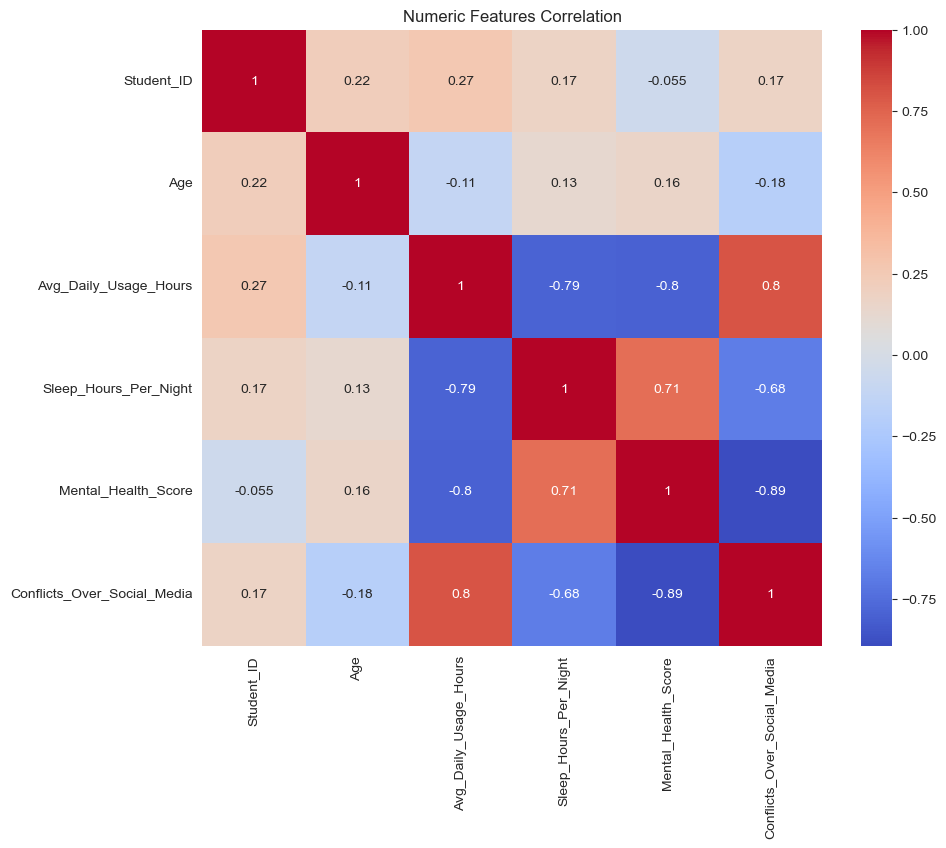

In [21]:
# 3.4 Correlation heatmap
corr = df[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Numeric Features Correlation')
plt.show()

In [23]:
# 4. Preprocessing
# 4.1 Identify numerical vs categorical columns
num_features = df.select_dtypes(include=['int64', 'float64']).columns.drop('Addicted_Score')
cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical:", num_features)
print("Categorical:", cat_features)

Numerical: Index(['Student_ID', 'Age', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night',
       'Mental_Health_Score', 'Conflicts_Over_Social_Media'],
      dtype='object')
Categorical: ['Gender', 'Academic_Level', 'Country', 'Most_Used_Platform', 'Affects_Academic_Performance', 'Relationship_Status']


In [25]:
# 4.2 Build preprocessing pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [29]:
# 5. Train‑test split
X = df.drop('Addicted_Score', axis=1)
y = df['Addicted_Score']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

In [30]:
# 6. Modeling: logistic regression pipeline
lr_pipeline = Pipeline([
    ('prep', preprocessor),
    ('clf', LogisticRegression(solver='liblinear', random_state=RANDOM_STATE))
])
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Student_ID', 'Age', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night',
       'Mental_Health_Score', 'Conflicts_Over_Social_Media'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Academic_Level',
                                                   'Country',
                                                   'Most_Used_Platform',
                                                   'Affects_Academic_Performance',
                                                   'Relationship_Status'])])),
                ('clf',
                 LogisticRegression(random_state=42, solver='liblinear'))])

In [34]:
# 7. Evaluation of logistic regression
y_pred = lr_pipeline.predict(X_test)
y_proba = lr_pipeline.predict_proba(X_test)[:, 1]

print("=== Logistic Regression Classification Report ===")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# For multiclass, get probability matrix
y_proba_all = lr_pipeline.predict_proba(X_test)

# Compute multiclass ROC AUC (one-vs-rest)
roc_auc = roc_auc_score(y_test, y_proba_all, multi_class='ovr')
print(f"ROC AUC Score (OvR): {roc_auc:.3f}")

# Plot ROC curve for each class
n_classes = y_proba_all.shape[1]
fpr = dict()
tpr = dict()
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=np.arange(y_proba_all.shape[1]))

for i in range(n_classes):
	fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba_all[:, i])
	plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc_score(y_test_bin[:, i], y_proba_all[:, i]):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend()
plt.show()

=== Logistic Regression Classification Report ===
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         2
           4       0.94      1.00      0.97        15
           5       1.00      1.00      1.00        35
           6       1.00      0.89      0.94         9
           7       0.98      0.98      0.98        41
           8       0.87      0.96      0.92        28
           9       0.88      0.70      0.78        10

    accuracy                           0.95       141
   macro avg       0.83      0.82      0.82       141
weighted avg       0.94      0.95      0.95       141

Confusion Matrix:
[[ 0  0  1  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0]
 [ 0  0 15  0  0  0  0  0]
 [ 0  0  0 35  0  0  0  0]
 [ 0  0  0  0  8  1  0  0]
 [ 0  0  0  0  0 40  1  0]
 [ 0  0  0  0  0  0 27  1]
 [ 0  0  0  0  0  0  3  7]]


c:\Users\acer\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\acer\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\acer\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'

In [ ]:
# 8. Try a more complex model: Random Forest
rf_pipeline = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
])

# Hyperparameter grid for tuning
param_grid = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 5, 10]
}

grid_search = GridSearchCV(
    rf_pipeline, param_grid, cv=5,
    scoring='roc_auc', n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best Params:", grid_search.best_params_)
print("Best CV AUC:", grid_search.best_score_)

best_rf = grid_search.best_estimator_

c:\Users\acer\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


Best Params: {'clf__max_depth': None, 'clf__n_estimators': 50}
Best CV AUC: nan


In [ ]:
# 9. Evaluate the best random forest
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

print("=== Random Forest Classification Report ===")
print(classification_report(y_test, y_pred_rf))

roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"RF Test ROC AUC: {roc_auc_rf:.3f}")

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr, tpr, label=f'LR (AUC = {roc_auc:.2f})', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Comparison')
plt.legend()
plt.show()

=== Random Forest Classification Report ===
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        35
           6       1.00      0.89      0.94         9
           7       0.98      1.00      0.99        41
           8       1.00      1.00      1.00        28
           9       1.00      1.00      1.00        10

    accuracy                           0.99       141
   macro avg       0.83      0.86      0.84       141
weighted avg       0.98      0.99      0.98       141



c:\Users\acer\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\acer\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\acer\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: multi_class must be in ('ovo', 'ovr')

In [35]:
# 11. Save the pipeline model
import joblib
joblib.dump(best_rf, 'best_model.pkl')

['best_model.pkl']